### Naver 영화 Review의 감성 분석 (한국어).

데이터 출처: https://github.com/e9t/nsmc/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline
%load_ext autotime

time: 0 ns (started: 2021-06-08 08:27:26 +09:00)


In [162]:
# import urllib.request
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x27c72d0bfd0>)

time: 2.26 s (started: 2021-06-07 11:07:54 +09:00)


#### 1. 데이터를 읽어오고 전처리 한다.

#### 1.1 기본 전처리.

1. CSV 파일이 아니다. Separator는 TAB이다.
2. 학습 데이터와 시험 데이터 따로 가져온다.
3. 데이터를 탐색해 본다.
4. 데이터에 중복이 있다면 제거한다.
5. 혹시 데이터에 공백인 셀이 있다면 제거가 필요할 수 있다.
6. 단음절, 특수문자, 여백 등을 제거한다 (정규표현식 활용).
7. 전처리 후 통계치 계산, 시각화 등을 실시해서 그 결과를 확인해 본다.

In [120]:
# 한국어 불용어 사전 모음으로 사전에 불용어 제거 
f=open('../data/koreanStopwords.txt', 'r', encoding='UTF8')
koreaStopWord=f.readlines()
f.close()

time: 0 ns (started: 2021-06-08 10:20:59 +09:00)


In [121]:
lst1=[]
for x in koreaStopWord:
    lst1.append(x[:-1].split('\t'))
    
lst2=[]
for j in lst1:
    lst2.append(j[0])
lst2=[x for x in lst2 if len(x)!=1]#길이가 2자 이상인 불용어 리스트 생성


def remove_stopwords(text): #불용어 처리 함수
    lst3=[]
    for t in text:
        okt =Okt()
        tokens = okt.morphs(t, stem=True)
        tokens = [ w for w in tokens if not w in lst2]
        tokens = [e for e in tokens if len(e)!=1]
        lst3.append(tokens)
    return lst3

time: 0 ns (started: 2021-06-08 10:20:59 +09:00)


In [122]:
# 학습 데이터와 시험 데이터 따로 가져옴 

train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

print("train set : {}개".format(train_data.shape[0]))
print("test set : {}개".format(test_data.shape[0]))

train set : 150000개
test set : 50000개
time: 360 ms (started: 2021-06-08 10:20:59 +09:00)


In [123]:
# Test 파일 불러오기 

f=open('../data/naver_movie_reviews_test.txt','r',encoding='UTF8')    # 테스트 파일불러오기
test=f.readlines()
f.close()

Test_lst=[]   #불러온Test파일 리스트화
for x in test:
    Test_lst.append(x[:-1].split('\t'))

test_data=pd.DataFrame(Test_lst[1:]) #데이터프레임으로변환
test_data.columns=Test_lst[0] #칼럼지정
test_df.drop_duplicates('id') #id 중복제거  >중복 x

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


time: 94 ms (started: 2021-06-08 10:20:59 +09:00)


In [124]:
# Train 파일 불러오기 

f=open('../data/naver_movie_reviews_train.txt','r',encoding='UTF8')    # 테스트 파일불러오기
train=f.readlines()
f.close()

Train_lst=[]   #불러온 Train파일 리스트화
for x in train:
    Train_lst.append(x[:-1].split('\t'))

train_data=pd.DataFrame(Train_lst[1:]) #데이터프레임으로변환
train_data.columns=Train_lst[0] #칼럼지정
train_data.drop_duplicates('id') #id 중복제거  >중복 x

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


time: 390 ms (started: 2021-06-08 10:21:00 +09:00)


In [125]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)
time: 0 ns (started: 2021-06-08 10:21:00 +09:00)


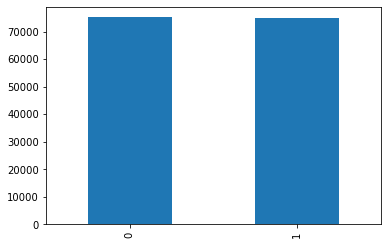

time: 94 ms (started: 2021-06-08 10:21:00 +09:00)


In [126]:
# 중복 제거전 학습 데이터 label 분포 확인

train_data['label'].value_counts().plot(kind = 'bar')
plt.show()

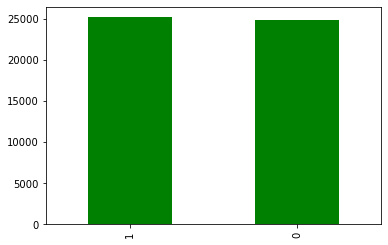

time: 78 ms (started: 2021-06-08 10:21:00 +09:00)


In [127]:
# 중복 제거 전 테스트 데이터 label 분포 확인

test_data['label'].value_counts().plot(kind = 'bar', color ='green')
plt.show()

In [128]:
# 긍/부정 label에 대한 정확한 값 
print(train_data.groupby('label').size().reset_index(name = 'count'))
print(test_data.groupby('label').size().reset_index(name = 'count'))

  label  count
0     0  75173
1     1  74827
  label  count
0     0  24827
1     1  25173
time: 15 ms (started: 2021-06-08 10:21:00 +09:00)


In [129]:
# 학습 데이터 셋 데이터 탐색
train_data['document'].nunique(), train_data['label'].nunique()
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
print('중복 제거 후 총 샘플의 수 :',len(train_data))

중복 제거 후 총 샘플의 수 : 146183
time: 156 ms (started: 2021-06-08 10:21:01 +09:00)


In [130]:
# 테스트 데이터 셋 데이터 탐색
test_data['document'].nunique(), test_data['label'].nunique()
test_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
print('중복 제거 후 총 샘플의 수 :',len(test_data))

중복 제거 후 총 샘플의 수 : 49158
time: 47 ms (started: 2021-06-08 10:21:01 +09:00)


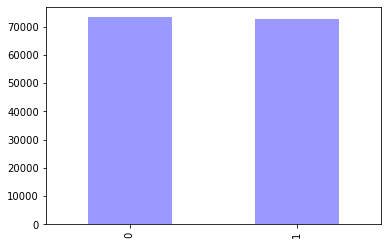

time: 110 ms (started: 2021-06-08 10:21:01 +09:00)


In [131]:
#중복 제거 후 학습 데이터 label 분포 확인

train_data['label'].value_counts().plot(kind = 'bar', color ='blue', alpha=0.4)
plt.show()

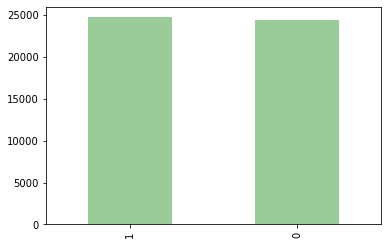

time: 78 ms (started: 2021-06-08 10:21:02 +09:00)


In [132]:
# 중복 제거 후 테스트 데이터 label 분포 확인

test_data['label'].value_counts().plot(kind = 'bar', color ='green', alpha=0.4)
plt.show()

In [133]:
# 긍/부정 label에 대한 정확한 값 
print(train_data.groupby('label').size().reset_index(name = 'count'))
print(test_data.groupby('label').size().reset_index(name = 'count'))

  label  count
0     0  73342
1     1  72841
  label  count
0     0  24446
1     1  24712
time: 15 ms (started: 2021-06-08 10:21:03 +09:00)


In [134]:
test_data.groupby('label').size().reset_index(name = 'count')

,label,count
0,0,24446
1,1,24712


time: 0 ns (started: 2021-06-08 10:21:03 +09:00)


In [135]:
# 특수문자 제외 , 단음절, 여백 제외 

train_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
train_data['document'] = train_data['document'].str.replace(pat=r'[^\w]', repl=r'', regex=True)
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['document'] = train_data['document'].str.replace("[^ㅏ-ㅣ가-힣 ]","")    #test 전처리
train_data['document'] = train_data['document'].str.replace("[.,;:|\)*~`!@#$?%^&*=+-_)>]","")
train_data['document'] = train_data['document'].str.replace("[0-9]","")
train_data['document'] = train_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
train_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
train_data = train_data.dropna(how='any') # Null 값 제거
print('전처리 후 훈련용 샘플의 개수 :',len(train_data))

<ipython-input-135-a5a972bd5f4b>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-135-a5a972bd5f4b>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㅏ-ㅣ가-힣 ]","")    #test 전처리
<ipython-input-135-a5a972bd5f4b>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[.,;:|\)*~`!@#$?%^&*=+-_)>]","")
<ipython-input-135-a5a972bd5f4b>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[0-9]","")
<ipython-input-135-a5a972bd5f4b>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  trai

전처리 후 훈련용 샘플의 개수 : 145278
time: 1.06 s (started: 2021-06-08 10:21:06 +09:00)


In [136]:
# 테스트 데이터도 수행

test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace(pat=r'[^\w]', repl=r'', regex=True) # 특수문자 제외
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace("[^ㅏ-ㅣ가-힣 ]","")    #test 전처리
test_data['document'] = test_data['document'].str.replace("[.,;:|\)*~`!@#$?%^&*=+-_)>]","")
test_data['document'] = test_data['document'].str.replace("[0-9]","")
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48789
time: 344 ms (started: 2021-06-08 10:22:01 +09:00)


<ipython-input-136-dce83f5ae053>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-136-dce83f5ae053>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㅏ-ㅣ가-힣 ]","")    #test 전처리
<ipython-input-136-dce83f5ae053>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[.,;:|\)*~`!@#$?%^&*=+-_)>]","")
<ipython-input-136-dce83f5ae053>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[0-9]","")
<ipython-input-136-dce83f5ae053>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['d

#### 1.2 토큰화 & 불용어 처리.

1. 자연어 자료를 분절 (토큰화) 처리한다. 모든 품사 또는 명사만을 사용할 수 있다.
2. 한글 불용어 사전을 만들어서 적용한다.
3. 데이터 분량을 줄이는 것도 고려해 본다.

In [137]:
okt = Okt()
X_Test = []
for sentence in test_data['document']:
    X_test = okt.morphs(sentence, stem=True) # 토큰화
    X_test = [word for word in X_test if not word in lst2] # 불용어 제거
    X_test = [x for x in X_test if len(x)!=1]
    X_Test.append(X_test)

time: 9min 33s (started: 2021-06-08 10:22:04 +09:00)


In [138]:
X_Train = []
for sentence in train_data['document']:
    X_train = okt.morphs(sentence, stem=True) # 토큰화
    X_train = [word for word in X_train if not word in lst2] # 불용어 제거
    X_train = [x for x in X_train if len(x)!=1]
    X_Train.append(X_train)

time: 27min 54s (started: 2021-06-08 10:31:38 +09:00)


In [198]:
X_Train[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,  8940,
           13,   154,   482],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   329,    28,   439,     1,  1185,    20,
          806,   496,    14],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,  1376,   404,
         3272,     2,   139],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  6194,    65,  7888,   131,    40,
            4,    18,  3499],
       [    0,     0,     0,

time: 0 ns (started: 2021-06-08 12:41:05 +09:00)


In [199]:
X_Test[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,   532],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    18,   305,    14,   380,
          152,   613,    16],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,    37,    14,    53,   251, 11277,
           41,    95,   176],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    16,  1979,    41,  2688,
          205, 10781,   597],
       [    0,     0,     0,

time: 0 ns (started: 2021-06-08 12:41:05 +09:00)


#### 1.3. Integer Encoding: 첫 시도.

1. 정수 인코딩 (integer encoding)을 적용해 본다. TensorFlow의 Tokenizer()를 사용한다.
2. 단어의 개수에 제한을 둘 필요가 있다. 모든 단어를 다 사용하는 것이 좋은 모델링은 아니다.
3. 인덱스 0은 padding의 용도로 사용될 것이기 때문에 +1 해야한다.
4. 인덱스 1은 OOV (out of vocabulary)를 나타내는 용도로 사용될 것이기 때문에 +1 해야 한다.
5. 정수 인코딩 후 혹시 빈 문장이 있으면 제거한다. <= 단어의 개수에 제약을 두었기 때문에 빈 문장이 새롭게 발생할 수도 있다!

In [141]:
# Integer Encoding 학습 실시!
tokenizer=Tokenizer(oov_token='<OOV')
tokenizer.fit_on_texts(X_Train)

time: 859 ms (started: 2021-06-08 11:27:45 +09:00)


In [142]:
# 결과 출력.
# word -> index 사전이 만들어 졌다.
# 빈도수 대로 index가 주어진다.
print(tokenizer.word_index)   #단어집합생성  >>빈도수 많은 순서대로   (41578 총개수)

{'<OOV': 1, '영화': 2, '보다': 3, '하다': 4, '없다': 5, '이다': 6, '좋다': 7, '너무': 8, '정말': 9, '재밌다': 10, '되다': 11, '같다': 12, '있다': 13, '진짜': 14, '않다': 15, '으로': 16, '아니다': 17, '에서': 18, '평점': 19, '최고': 20, '연기': 21, '스토리': 22, '이영화': 23, '드라마': 24, '감동': 25, '만들다': 26, '나오다': 27, '아깝다': 28, '보고': 29, '재미있다': 30, '배우': 31, '감독': 32, '하고': 33, '들다': 34, '그냥': 35, '재미없다': 36, '까지': 37, '지루하다': 38, '가다': 39, '쓰레기': 40, '재미': 41, '주다': 42, '모르다': 43, '작품': 44, '알다': 45, '오다': 46, '자다': 47, '그렇다': 48, '사랑': 49, '마지막': 50, 'ㅠㅠ': 51, '이나': 52, '많다': 53, '완전': 54, '처음': 55, '안되다': 56, '액션': 57, '이렇게': 58, '주인공': 59, '최악': 60, '내용': 61, 'ㅡㅡ': 62, '느낌': 63, '이렇다': 64, '싶다': 65, '이야기': 66, '인데': 67, '넘다': 68, '좋아하다': 69, '연출': 70, '명작': 71, '받다': 72, '장면': 73, '역시': 74, '많이': 75, '늘다': 76, '남다': 77, '차다': 78, '괜찮다': 79, '버리다': 80, '이건': 81, '라고': 82, '느끼다': 83, '별로': 84, '부터': 85, '아름답다': 86, '나다': 87, '먹다': 88, '야하다': 89, '해주다': 90, '무슨': 91, '뻔하다': 92, '결말': 93, '끄다': 94, '이고': 95, '보기': 96, '지만': 97, '보여

In [143]:
# 도수표 출력.
print(tokenizer.word_counts)

OrderedDict([('아더', 9), ('진짜', 7989), ('짜증나다', 1016), ('목소리', 370), ('포스터', 548), ('보고', 4233), ('초딩', 411), ('영화', 44386), ('오버', 139), ('연기', 5372), ('조차', 212), ('가볍다', 360), ('않다', 7705), ('무재', 118), ('밓었', 1), ('다그', 449), ('래서', 39), ('보다', 37630), ('추천', 1136), ('교도소', 16), ('이야기', 2066), ('구먼', 11), ('솔직하다', 1196), ('재미', 3441), ('없다', 15208), ('평점', 6179), ('조정', 36), ('사이', 200), ('몬페', 3), ('익살스럽다', 9), ('돋보이다', 287), ('스파이더맨', 63), ('에서', 6454), ('늙다', 199), ('보이다', 900), ('하다', 24038), ('크다', 1154), ('스틴던스트', 5), ('너무나도', 205), ('이쁘다', 1048), ('걸음', 17), ('떼다', 153), ('초등학교', 116), ('학년', 122), ('생인', 6), ('살다', 1039), ('반개', 191), ('아깝다', 4343), ('원작', 1177), ('긴장감', 827), ('을제', 73), ('대로', 613), ('살리다', 501), ('다욕', 35), ('나오다', 4469), ('이응경', 7), ('길용우', 4), ('생활', 120), ('몇년', 24), ('인지', 1132), ('정말', 9373), ('해도', 470), ('보단', 447), ('낫다', 480), ('납치', 48), ('감금', 11), ('반복', 138), ('드라마', 4857), ('가족', 900), ('액션', 2325), ('재미있다', 4189), ('안되다', 2396), ('왜케', 114)

In [144]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 44119
등장 빈도가 2번 이하인 희귀 단어의 수: 24455
단어 집합에서 희귀 단어의 비율: 55.429633491239606
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.472530618320773
time: 16 ms (started: 2021-06-08 11:27:48 +09:00)


In [145]:
cnt=0  #단어빈도수가 2개 미만인 단어종류 개수
cnt2=0  #2개미만인단어가 차지하는 개수

for key, value in tokenizer.word_counts.items():
    if(value<2):
        cnt=cnt+1 #개수 카운트
print(cnt)

18680
time: 0 ns (started: 2021-06-08 11:27:50 +09:00)


In [146]:
cnt2=41578-cnt
print(cnt2)

22898
time: 0 ns (started: 2021-06-08 11:27:50 +09:00)


In [147]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19665
time: 0 ns (started: 2021-06-08 11:27:51 +09:00)


In [148]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_Train)
X_Train = tokenizer.texts_to_sequences(X_Train)
X_Test = tokenizer.texts_to_sequences(X_Test)

time: 1.78 s (started: 2021-06-08 11:27:52 +09:00)


In [149]:
# 상위 5개 샘플만 출력

print(X_Train[:5])

[[8940, 13, 154, 482], [329, 28, 439, 1, 1185, 20, 806, 496, 14], [1376, 404, 3272, 2, 139], [6194, 65, 7888, 131, 40, 4, 18, 3499], [853, 16413, 8941, 20, 619, 1, 2209, 17, 857, 185, 3, 136, 12686, 830, 149, 185]]
time: 0 ns (started: 2021-06-08 11:27:54 +09:00)


In [150]:
y_Train = np.array(train_data['label'])
y_Test = np.array(test_data['label'])

time: 15 ms (started: 2021-06-08 11:28:12 +09:00)


In [151]:
drop_Train = [index for index, sentence in enumerate(X_Train) if len(sentence) < 1]

time: 15 ms (started: 2021-06-08 11:28:13 +09:00)


In [152]:
# 빈 샘플들을 제거

X_Train = np.delete(X_Train, drop_Train, axis=0)
y_Train = np.delete(y_Train, drop_Train, axis=0)
print(len(X_Train))
print(len(y_Train))

144220
144220
time: 78 ms (started: 2021-06-08 11:28:13 +09:00)


C:\Users\PC\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 1.4. Padding 적용.

1. 문장 길이의 분포를 탐색해 본다. HINT: 히스토그램 활용.
2. Padding을 적용해 본다. HINT: pad_sequences() 함수 사용.

리뷰의 최대 길이 : 67
리뷰의 평균 길이 : 8.267965608098738


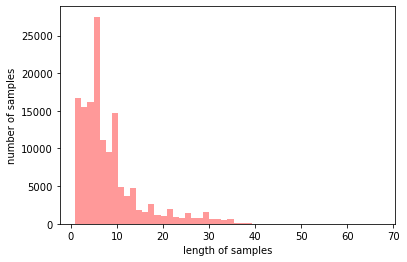

time: 594 ms (started: 2021-06-08 11:28:18 +09:00)


In [153]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_Train))
print('리뷰의 평균 길이 :',sum(map(len, X_Train))/len(X_Train))
plt.hist([len(s) for s in X_Train], bins=50, color='red', alpha=0.4)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [154]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

time: 0 ns (started: 2021-06-08 11:28:20 +09:00)


In [155]:
max_len = 30
below_threshold_len(max_len, X_Train)  # 약 94%의 리뷰가 30이하의 길이를 가지는 것을 확인함 

전체 샘플 중 길이가 30 이하인 샘플의 비율: 97.96560809873804
time: 15 ms (started: 2021-06-08 11:28:21 +09:00)


In [156]:
X_Train = pad_sequences(X_Train, maxlen = max_len)
X_Test = pad_sequences(X_Test, maxlen = max_len)

time: 672 ms (started: 2021-06-08 11:28:21 +09:00)


In [164]:
X_Train[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 8940,   13,  154,  482],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  329,
          28,  439,    1, 1185,   20,  806,  496,   14]])

time: 0 ns (started: 2021-06-08 11:31:17 +09:00)


In [161]:
X_Test

array([[   0,    0,    0, ...,    0,    0,  532],
       [   0,    0,    0, ...,  152,  613,   16],
       [   0,    0,    0, ...,   41,   95,  176],
       ...,
       [   0,    0,    0, ...,    2, 2839,   25],
       [   0,    0,    0, ...,   17, 1925,   87],
       [   0,    0,    0, ...,  709, 5509,  737]])

time: 0 ns (started: 2021-06-08 11:30:45 +09:00)


#### 2. LSTM 사용한 모델링과 학습.

1. LSTM 모델을 정의한다. 
2. Hyperparameter를 정의한다.
3. Callback 정의.
4. Optimizer 객체 생성과 모델 컴파일.
5. 학습 실행.
6. 예측 정확도 계산 (학습 데이터 사용).

In [200]:
n_epochs=15
batch_size=128
n_words = cnt + 2
DIM = 100                                                            # Embedding 차원수.
n_hidden = 128

time: 0 ns (started: 2021-06-08 12:41:19 +09:00)


In [201]:
my_model = Sequential()
my_model.add(Embedding(n_words,DIM))
my_model.add(LSTM(units=n_hidden, return_sequences=False))            # Sequence To Vector.
my_model.add(Dense(units=1, activation='sigmoid'))                     # 긍/부정 감성.

time: 250 ms (started: 2021-06-08 12:41:19 +09:00)


In [202]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

time: 0 ns (started: 2021-06-08 12:41:19 +09:00)


In [203]:
my_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = my_model.fit(X_Train, y_Train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15


UnimplementedError:  Cast string to float is not supported
	 [[node binary_crossentropy/Cast (defined at <ipython-input-203-9a4c925d9175>:2) ]] [Op:__inference_train_function_19369]

Function call stack:
train_function


time: 1.56 s (started: 2021-06-08 12:41:20 +09:00)


In [ ]:
# 정확도가 가장 높았을 때 best_model.h5로 로드 
#loaded_model = load_model('best_model.h5')
#print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1])

In [ ]:
# 학습 history 출력. 
plt.plot(my_summary.history['accuracy'], c="b")
plt.plot(my_summary.history['val_accuracy'], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#### 3. 감성 예측.

- 다음과 같이 헬퍼함수 sentiment_prediuct를 정의하여 감성 예측을 실시해 본다!

In [291]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰.\n".format((1 - score) * 100))

time: 0 ns (started: 2021-06-07 16:23:34 +09:00)


In [34]:
# A testing case.
sentiment_predict('꿀잼 ㅎㅎㅎ  강추! ㅋㅋㅋ')

Positive review with probability = 99.32%.



In [35]:
# A testing case.
sentiment_predict('이런 망작이~~')

Negative review with probability = 92.53%.



In [36]:
# A testing case.
sentiment_predict('들인 돈이 아깝다')

Negative review with probability = 90.62%.



In [37]:
# A testing case.
sentiment_predict('이번 주말에 연인과 함께 시청 추천해요!')

Positive review with probability = 87.51%.



In [38]:
# A testing case.
sentiment_predict('낮은 기대치 만큼 역시나 볼것 없는 영화였다.')

Positive review with probability = 85.91%.



### 워드클라우드